# Analysis of block production for a nine-node cluster

This notebook checks basic statistics for a cluster of nine `cardano-node` instances comprising a private testnet.

## Load libraries

In [1]:
#require(curl)
require(data.table)
require(ggplot2)
#require(lubridate)
require(magrittr)

Loading required package: data.table

Loading required package: ggplot2

Loading required package: magrittr



## Read data

In [2]:
chain <- fread("http://ipfs.functionally.io/ipfs/QmUZU24a3SoKYqHb858gT7DQ1eu13vBBAfeoRF2S3QgGjj")
chain <- chain[`blockNo` <= chain[, .(`blockNo`=max(`blockNo`)), by=.(`node`)][, min(`blockNo`)]]
chain %>% summary

    party                node             at                        
 Length:41760       Min.   :1.000   Min.   :2024-11-02 21:01:45.43  
 Class :character   1st Qu.:3.000   1st Qu.:2024-11-03 02:41:06.82  
 Mode  :character   Median :5.000   Median :2024-11-03 08:16:29.90  
                    Mean   :5.005   Mean   :2024-11-03 08:18:57.38  
                    3rd Qu.:7.000   3rd Qu.:2024-11-03 13:57:50.32  
                    Max.   :9.000   Max.   :2024-11-03 19:37:39.70  
    block              blockNo       blockPrev              slot       
 Length:41760       Min.   :    0   Length:41760       Min.   :    54  
 Class :character   1st Qu.:10192   Class :character   1st Qu.:203668  
 Mode  :character   Median :20364   Mode  :character   Median :404899  
                    Mean   :20378                      Mean   :406374  
                    3rd Qu.:30573                      3rd Qu.:609703  
                    Max.   :40788                      Max.   :813597  

## Parameters

### Active-slot coefficient

In [3]:
f <- 1 / 20

### Number of nodes

In [4]:
nodeCount <- chain[, `node` %>% unique %>% length]
nodeCount 

[1] 9

### Maximum slot

In [5]:
slotMax <- chain[, `slot` %>% max]
slotMax

[1] 813597

### Maximum block

In [6]:
blockMax <- chain[, `blockNo` %>% max]
blockMax

[1] 40788

### Number of blocks

In [7]:
blockCount <- chain[, `blockNo` %>% length]
blockCount

[1] 41760

## Basic diagnostics

### Blocks per slot

In [8]:
chain[, max(`blockNo`) / max(`slot`)]

[1] 0.05013293

In [9]:
chain[, max(`blockNo`) / max(`slot`)] / f

[1] 1.002659

### Check that all blocks are present

Forging is sometimes not recorded in the log, especially if the log rate is high.

Let's see which block numbers are missing from the log, if any.

In [10]:
chain[, setdiff(0:blockMax, `blockNo` %>% unique)]

integer(0)

## Diagnostics for probabilities

Plot a histogram of the number of blocks produced by each node.

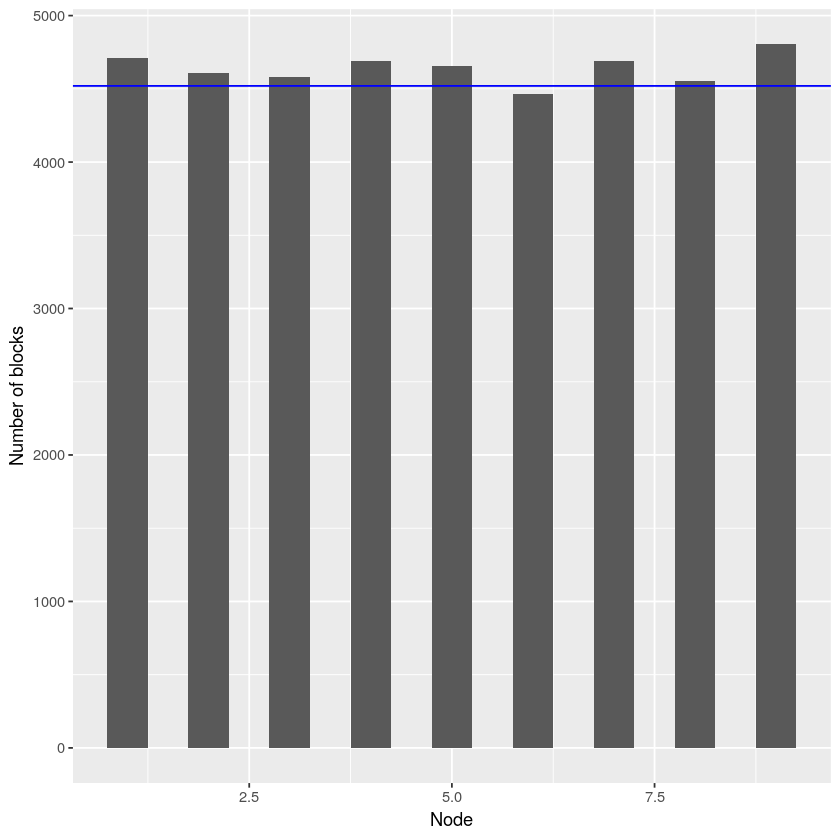

In [11]:
ggplot(chain, aes(x=`node`)) +
  geom_histogram(binwidth=0.5) +
  geom_hline(yintercept=slotMax*f/nodeCount, color="blue") +
  xlab("Node") +
  ylab("Number of blocks")

### Chi-squared test that the correct number of blocks are produced.

The p-value indicates that the expected number of blocks were produced.

In [12]:
chisq.test(c(blockMax, slotMax - blockMax), p=c(f, 1 - f))


	Chi-squared test for given probabilities

data:  c(blockMax, slotMax - blockMax)
X-squared = 0.30266, df = 1, p-value = 0.5822


### Chi-squared test that the nodes are producing at the same rate

The p-value indicates that the nodes are indeed producing at the same rate.

In [13]:
chisq.test(chain[, table(`node`)])


	Chi-squared test for given probabilities

data:  chain[, table(node)]
X-squared = 16.979, df = 8, p-value = 0.03033


### Tests of gaps in block production

Compute the gaps between successive blocks, measured in slots.

In [14]:
gaps <- chain[, .(`Gap [slot]` = `slot` %>% unique %>% sort %>% diff - 1)]
gaps %>% summary

   Gap [slot]    
 Min.   :  0.00  
 1st Qu.:  5.00  
 Median : 13.00  
 Mean   : 18.94  
 3rd Qu.: 26.00  
 Max.   :214.00  

#### Chi-squared test

The gaps should be geometrically distributed.

In [15]:
gapsExpected <- data.table(`Gap [slot]`=0:gaps[,max(`Gap [slot]`)])
gapsExpected[, `count` := (slotMax - 1) * f * dgeom(0:gaps[,max(`Gap [slot]`)], p=f)]
gapsExpected %>% summary

   Gap [slot]        count          
 Min.   :  0.0   Min.   :   0.0348  
 1st Qu.: 53.5   1st Qu.:   0.5409  
 Median :107.0   Median :   8.4096  
 Mean   :107.0   Mean   : 189.2053  
 3rd Qu.:160.5   3rd Qu.: 130.8291  
 Max.   :214.0   Max.   :2033.9900  

Plot a histogram.

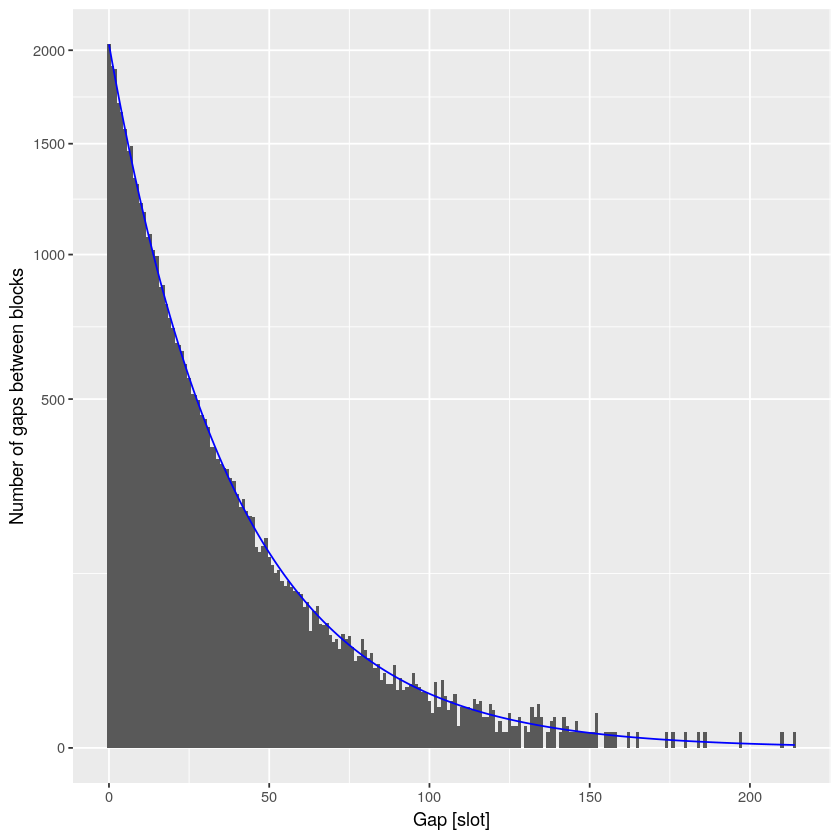

In [16]:
ggplot(gaps, aes(x=`Gap [slot]`)) +
    geom_histogram(binwidth=1) +
    geom_line(data=gapsExpected, aes(x=`Gap [slot]`, y=`count`), color="blue") +
    scale_y_sqrt() +
    ylab("Number of gaps between blocks")

In [17]:
gapsTable <- gaps %>% table
gapsProbabilities <- dgeom(as.numeric(names(gapsTable)), p=f)

According to a chi-squared test, the observations do not conform to the expected geometric distribution.

In [18]:
options(warn=-1)
chisq.test(c(gapsTable, 0), p = c(gapsProbabilities, 1 - sum(gapsProbabilities)))
options(warn=0)


	Chi-squared test for given probabilities

data:  c(gapsTable, 0)
X-squared = 285.55, df = 164, p-value = 1.295e-08


#### Kolmogorov-Smirnov test

A quantile-quantile plot indicates that the tail of the observations is more extreme than expected.

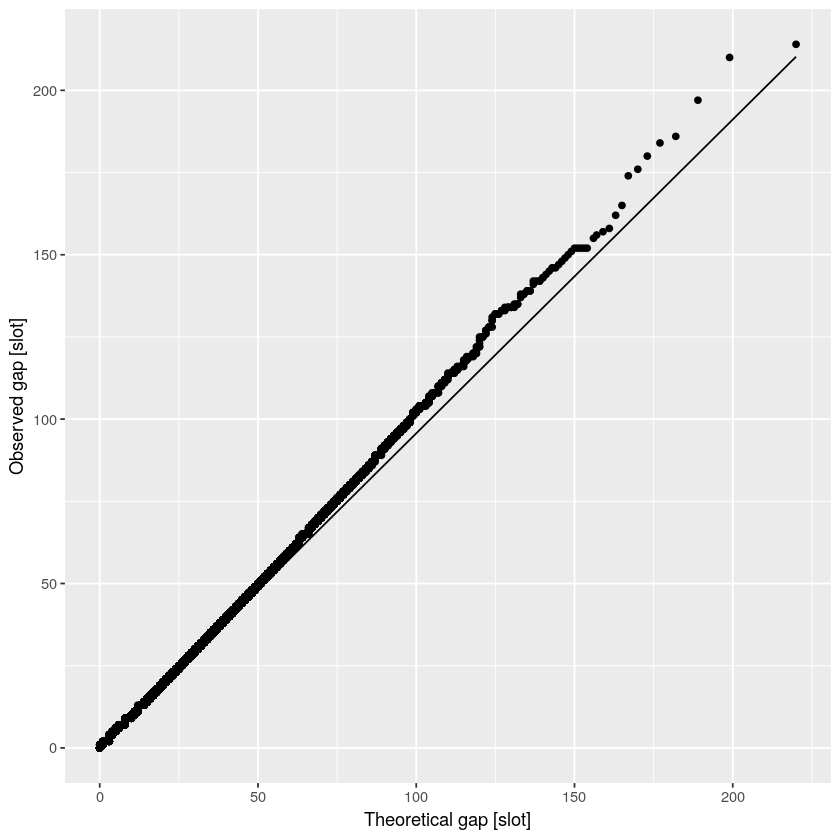

In [19]:
ggplot(gaps, aes(sample=`Gap [slot]`)) +
    stat_qq(distribution=qgeom, dparams=f) +
    stat_qq_line(distribution=qgeom, dparams=f) +
    xlab("Theoretical gap [slot]") +
    ylab("Observed gap [slot]")

The K-S test also indicates the the observations are not geometrically distributed.

In [20]:
ks.test(gaps[, `Gap [slot]` %>% jitter], "pgeom", f)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  gaps[, `Gap [slot]` %>% jitter]
D = 0.025658, p-value < 2.2e-16
alternative hypothesis: two-sided


#### Repeat on a node-by-node basis

In [21]:
gaps <- chain[, .(`Gap [slot]` = `slot` %>% sort %>% diff -1), by=.(`node`)]
gaps %>% summary

      node         Gap [slot]    
 Min.   :1.000   Min.   :   0.0  
 1st Qu.:3.000   1st Qu.:  49.0  
 Median :5.000   Median : 120.0  
 Mean   :5.005   Mean   : 174.3  
 3rd Qu.:7.000   3rd Qu.: 240.0  
 Max.   :9.000   Max.   :2640.0  

Nodes have a lower rate of block production than the system as a whole.

In [22]:
fn <- 1-(1-f)^(1/nodeCount)
fn

[1] 0.005683045

In [23]:
gapsExpected <- data.table(`Gap [slot]`=0:gaps[,max(`Gap [slot]`)])
gapsExpected[, `count` := (slotMax - 1) * fn * dgeom(0:gaps[,max(`Gap [slot]`)], p=fn)]
gapsExpected %>% summary

   Gap [slot]       count          
 Min.   :   0   Min.   : 0.000008  
 1st Qu.: 660   1st Qu.: 0.000330  
 Median :1320   Median : 0.014203  
 Mean   :1320   Mean   : 1.750739  
 3rd Qu.:1980   3rd Qu.: 0.610898  
 Max.   :2640   Max.   :26.276710  

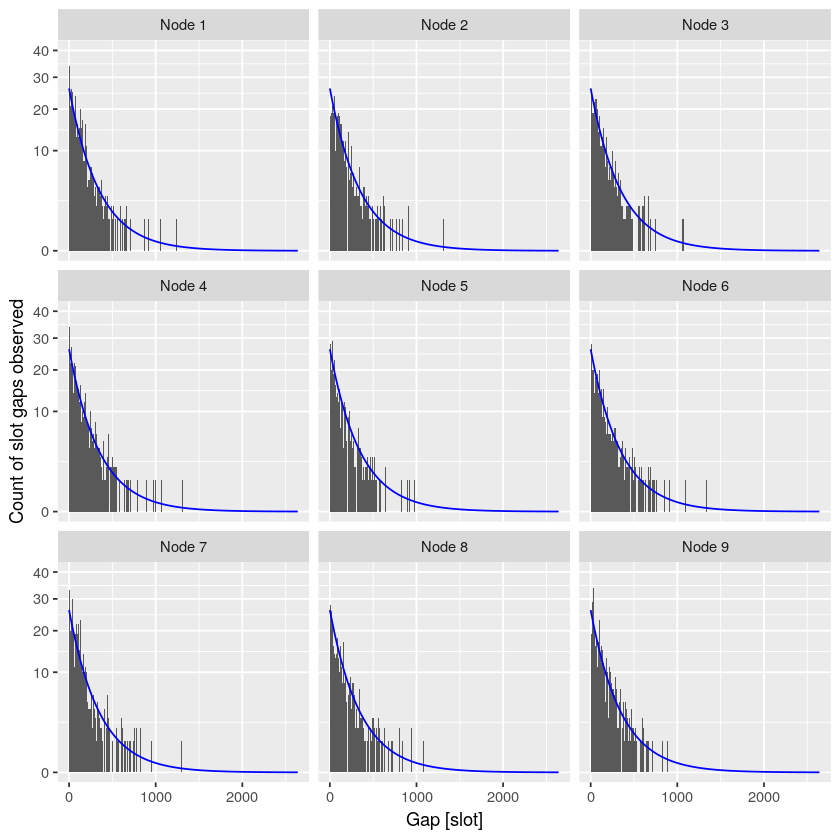

In [24]:
ggplot(gaps, aes(x=`Gap [slot]`)) +
    geom_histogram(binwidth=1) +
    geom_line(data=gapsExpected, aes(x=`Gap [slot]`, y=`count`), color="blue") +
    scale_y_sqrt() +
    facet_wrap(. ~ paste("Node", node)) + 
    ylab("Count of slot gaps observed")

These would also fail chi-squared tests.

#### Repeat, but for gaps in blocks instead of slots.

In [25]:
gaps <- chain[, .(`Gap [block]` = `blockNo` %>% sort %>% diff -1), by=.(`node`)]
gaps %>% summary

      node        Gap [block]    
 Min.   :1.000   Min.   :  0.00  
 1st Qu.:3.000   1st Qu.:  2.00  
 Median :5.000   Median :  5.00  
 Mean   :5.005   Mean   :  7.79  
 3rd Qu.:7.000   3rd Qu.: 11.00  
 Max.   :9.000   Max.   :112.00  

In [26]:
gapsExpected <- data.table(`Gap [block]`=0:gaps[,max(`Gap [block]`)])
gapsExpected[, `count` := (blockMax - 1) / nodeCount * dgeom(0:gaps[,max(`Gap [block]`)], p=1/nodeCount)]
gapsExpected %>% summary

  Gap [block]      count         
 Min.   :  0   Min.   :  0.0009  
 1st Qu.: 28   1st Qu.:  0.0254  
 Median : 56   Median :  0.6879  
 Mean   : 56   Mean   : 40.1051  
 3rd Qu.: 84   3rd Qu.: 18.6108  
 Max.   :112   Max.   :503.5432  

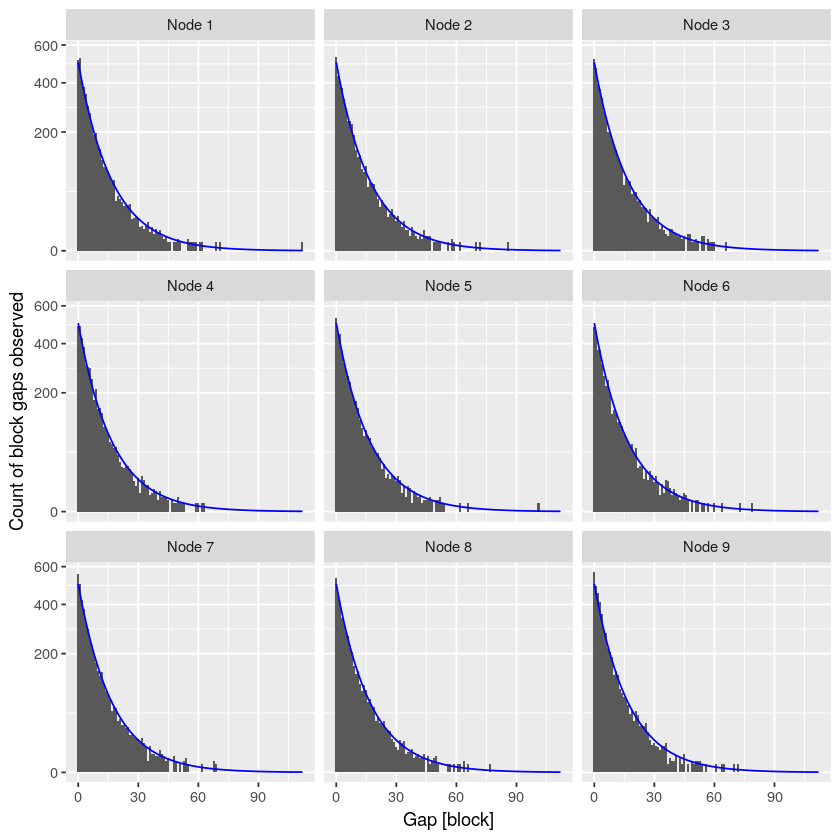

In [27]:
ggplot(gaps, aes(x=`Gap [block]`)) +
    geom_histogram(binwidth=1) +
    geom_line(data=gapsExpected, aes(x=`Gap [block]`, y=`count`), color="blue") +
    scale_y_sqrt() +
    facet_wrap(. ~ paste("Node", node)) +
    ylab("Count of block gaps observed")

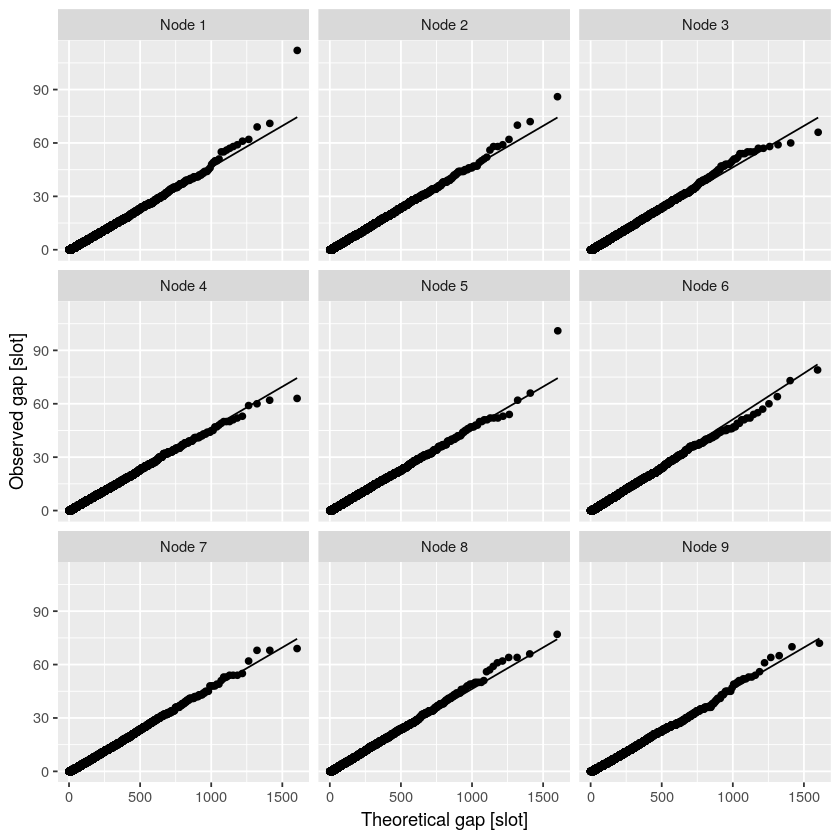

In [28]:
ggplot(gaps, aes(sample=`Gap [block]`)) +
    stat_qq(distribution=qgeom, dparams=fn) +
    stat_qq_line(distribution=qgeom, dparams=fn) +
    facet_wrap(. ~ paste("Node", `node`)) +
    xlab("Theoretical gap [slot]") +
    ylab("Observed gap [slot]")